<a href="https://colab.research.google.com/github/IStarWatcher/ANN/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0__%D0%A2%D0%B5%D0%BC%D0%B0_8_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE_%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C_(GAN)_%D0%A7%D0%B0%D1%81%D1%82%D1%8C_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Тема 8. Генеративно-состязательная сеть (GAN). Часть 1**

# Устройство GAN

GAN — Generative adversarial Network — генеративно-состязательная сеть. Эта архитектура была придумана в 2014 году специально для задачи генерации новых изображений
(конечно, ГАНы можно при этом использовать для генерации не только картинок, но и других объектов).

Давайте подумаем: **как можно научить нейросеть генерировать новые объекты?**

Самая простая идея: сделать нейросеть, которая на вход будет получать слечайный вектор чисел определенного размера, а на выходе выдавать сгенерированную картинку:

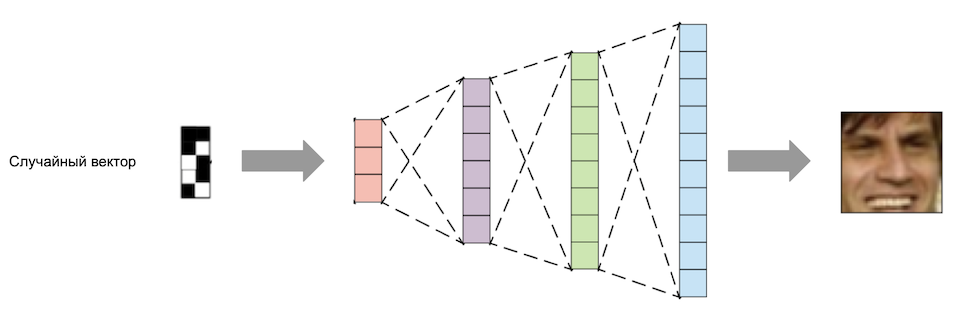

Проблема в этой идее в том, как такую сеть обучать. Если при обучении подавать на вход случайные векторы и выход сети сравнивать с картинками из обучающего датасета, такая сеть научится генерировать только картинки из обучающего датасета. Это довольно бесполезно =)

Хотелось бы, имея ограниченный обучающий датасет, научить нейросеть генерировать разные лица людей. Даже такие, которых нейросеть не видела в процессе обучения (т.е. которых нет в обучающих данных).

Как это сделать? Одна из идей — GAN — генеративно-состязательная сеть.
Вот как она устроена:

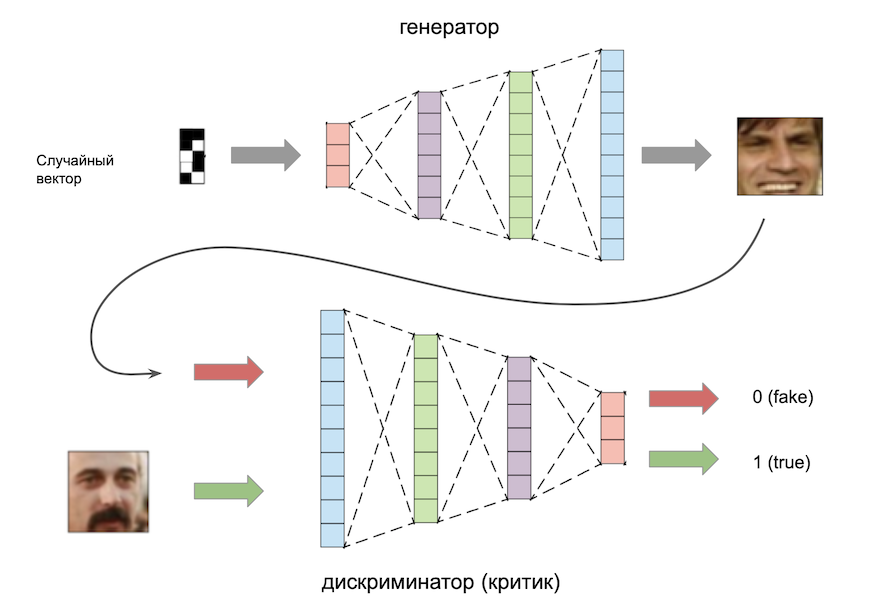

Модель состоит из двух отдельных нейросетей: генератора и дискриминатора. Генератор принимает на вход случайный вектор и выдает на выходе картинку. Дискриминатор принимает на вход картинку и выдает ответ: реальная ли эта картинка или фейковая (сгенерированная генератором).

Генератор и дискриминатор обучаются совместно. Дискриминатор помогает генератору научиться генерировать разнообразные картинки, а не только те, что есть в обучающем датасете.

[Слайды](https://docs.google.com/presentation/d/1g3xC7OKRLWJLAtnjyrQroI_N97ZOJScfDFnGxKkI7gs/edit?usp=sharing) о том, как происходит обучение такой модели.

Смысл в этом всем такой: дискриминатор быстро учится отличать картинки, сгенерированные генератором, от настоящих (из обучающего датасета). После этого на стадии обучения генератора генератор учится подстраиваться так, чтобы генерировать картинки, которые дискриминатор отличить от настоящих уже не сможет. После этого дискриминатор учится отличать новые картинки, сгенерированные генератором, от настоящих. После этого снова генератор учится генерировать картинки лучше. И так далее.

Это такаое противостояние между генератором и дискриминатором.

**У ГАНов есть некоторые недостатки**:

- ГАН довольно сложно обучить. Нужно подобрать правильные архитектуры генератора и дискриминатора: чтобы дискриминатор был не слишком "умнее" генератора (не обучался хорошо классифицировать картинки сильно быстрее, чем генератор научится хорошо их генерировать). И наоборот: дискриминатор не должен быть сильно "тупее" генератора, иначе генератор не будет получать хороший сигнал для обучения.
- В генераторе ГАНа нужно очень осторожно использовать batchnorm. BatchNorm выравнивает распределения всех элементов батча, из-за этого все сгенерированные в одном батче картинки могут иметь похожие характеристики.
Пример генерации с использованием BatvhNorm:


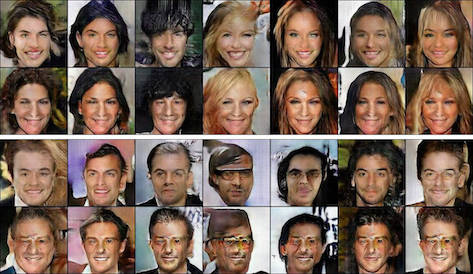

- у ГАНов часто возникает mode collapse: ситуация, когда генератор начинает генерировать примерно одинаковые картинки на любые входные случайные векторы. Есть много техник, как уменьшить такой эффект и сделать генерацию генератора более разнообразной. Пример mode collapse:

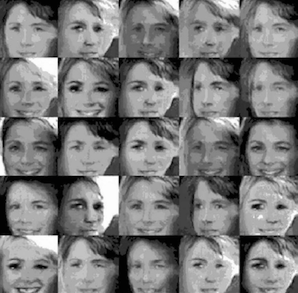

Вариации GAN: [ссылка](https://www.wisdom.weizmann.ac.il/~vision/courses/2018_2/Advanced_Topics_in_Computer_Vision/files/DomainTransfer.pdf)

# **Задание №1.** Обучите генератор воспризводить примитивные изображения. Датасет выберите по желанию.

Установим зависимости:

In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU, ELU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
from imutils import paths
import cv2
import os

Определяем размеры входного изображения (Большие изображения требуют слишком много времени и ресурсов)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

### Обработка изображений

In [ ]:
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/maga/dl/datasets/notes")))
random.shuffle(imagePaths)

In [ ]:
def load_images(imagePaths, compression_size = 32):
  data = []
  labels = []

  for imagePath in imagePaths:
    # Загрузка изображения
    image = cv2.imread(imagePath)

    # Изменение разрешения изображения
    image = cv2.resize(image, (compression_size, compression_size))

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Инвертирую изображение
    #image = 255 - image
    # Добавление изображения в список
    data.append(image)

    # Извлечение метки класса из пути к изображению
    label = imagePath.split(os.path.sep)[-2]

    # Добавление метки в список
    labels.append(label)

  data = np.array(data)

  return data, labels

In [ ]:
X_train, _ = load_images(imagePaths, 28)
np.save('/content/drive/MyDrive/maga/dl/datasets/notes_numpy/notes.npy', X_train)

## Конструктор Генератора:

Построим архитектуру Генератора: (Здесь мы используем только полносвязные слои. Но сеть может быть усложнена в зависимости от применения)

Используемая функция активации [LeakyReLU](https://habr.com/ru/articles/727506/)

In [ ]:
def build_generator():
    # Вектор случайного шума, используемый в качестве входного слоя для Генератора:
    noise_shape = (100,) # 1D массив размером 100 (латентный вектор / шум)

    model = Sequential()

    #Alpha - α - это гиперпараметр, который управляет базовым значением, на который функция
    # функция домножает отрицательные входы сети.
    #Momentum - «задержка» в обучении среднего значения и дисперсии, поэтому шум из-за мини-пакета можно игнорировать
    # Ссылка: https://medium.com/@ilango100/batchnorm-fine-tune-your-booster-bef9f9493e22

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))#model.add(ELU(alpha=0.2))#
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    # Генерация изображения

    return Model(noise, img)

## Конструктор Дискриминатора:

Построим модель Дискриминатора:

Для входного изображения дискриминатор выдает вероятность того, что изображение является реальным. (По сути это бинарный классификатор - определяем истина или ложь)

In [ ]:
def build_discriminator():


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(ELU(alpha=0.2))#model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)  # предположение дискриминатора о том, является ли входное изображение реальным или нет.

    return Model(img, validity)

## Функции для сохранения и загрузки параметров моделей (GAN, Generator, Discriminator) с возможностью дообучения

In [ ]:
from tensorflow.keras.models import load_model, save_model

def save(gan, generator, discriminator):
    root_path = ''
    discriminator.trainable = False
    save_model(gan, root_path+'gan')
    discriminator.trainable = True
    save_model(generator, root_path + 'generator')
    save_model(discriminator, root_path + 'discriminator')

In [ ]:
def load():
    root_path = ''
    discriminator = load_model(root_path + 'discriminator')
    generator = load_model(root_path + 'generator')
    gan = load_model(root_path + 'gan')
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

## Функция обучения:

Теперь, когда мы создали две наши модели, пришло время связать их друг с другом.

Мы делаем это, определяя функцию обучения, загружая набор данных, изменяя масштаб наших обучающих изображений.

In [ ]:
def train(epochs, batch_size=128, save_interval=50):
    #compression_size = 28
    # Загружаем набор данных
    #X_train, _ = load_images(imagePaths, compression_size)
    X_train = np.load("/content/drive/MyDrive/maga/dl/datasets/notes_numpy/notes.npy")
    # Преобразование в тип float и нормализация от -1 до 1 (можно также от 0 до 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    #Добавляем размерность каналов. В качестве входных данных для наших gen и discr. имеет форму 28x28x1.
    #X_train = np.expand_dims(X_train, axis=3)
    half_batch = int(batch_size / 2)


    #Обучаем Дискриминатор,
    # выбираем случайную партию изображений из нашего истинного набора данных,
    # генерируем набор изображений с помощью Генератора, затем подаём оба набора изображений в наш Дискриминатор,
    # и, наконец, вычисляем параметры функции потерь для реальных и сгенерированных
    #  (поддельных) изображений, а также комбинированные потери.

    for epoch in range(epochs):

        # ---------------------
        #  Обучение Дискриминатора
        # ---------------------

        # Выберите случайную половину партии реальных изображений
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]


        noise = np.random.normal(0, 1, (half_batch, 100))

        # Сгенерируем половину партии поддельных изображений
        gen_imgs = generator.predict(noise)

        # Обучение дискриминатора на реальных и поддельных изображениях отдельно.
        # Исследования показали, что раздельное обучение более эффективно.
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

        # Процесс обучения происходит с помощью метода train_on_batch()
        # Ссылка:https://keras.io/api/models/model_training_apis/

        # Вычисление средней потери от реальных и поддельных изображений.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #И в том же цикле мы обучаем наш Генератор, задавая входной шум
        # и в конечном итоге обучая Генератор тому, чтобы Дискриминатор
        # помечал его образцы как достоверные задавая градиентные потери.

        # ---------------------
        #  Обучение Генератора
        # ---------------------

        #Создаём векторы случайного шума в качестве входных данных для генератора.
        # На каждую партию необходимо создать свой вектор.
        # Шум основано на нормальном распределении (от 0 до 1).
        # Выходные данные будут иметь размер (размер партии, 100)

        noise = np.random.normal(0, 1, (batch_size, 100))

        # Генератору необходимо добиться того, чтобы дискриминатор пометил сгенерированные образцы
        # как истинные (1)
        # Здесь генератор пытается "обмануть" дискриминатор, чтобы тот "поверил", в то
        # что сгенерированный образ является истинным (отсюда значение 1 для y)
        valid_y = np.array([1] * batch_size) #Создает массив всех единиц размера size=batch size

        # Генератор является частью комбинированной системы, где он напрямую связан с дискриминатором.
        # Обучим генератор, используя шум в качестве x и 1 в качестве y.
        # Опять же, 1 в качестве выхода, так как он состязательный,
        # и если генератор отлично справился со своей р работой по следованию дискриминатору, то на выходе будет 1 (истина).

        g_loss = combined.train_on_batch(noise, valid_y)


#Дополнительно, чтобы мы могли отслеживать процесс обучения, мы выводим на печать
# прогресс и сохраняем вывод образцов изображений в зависимости от заданного интервала эпох,
# а также по желанию, можем сохранять модель.

        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)
            if epoch % 1000 == 0:
                # save(combined, generator, discriminator)
                save(combined, generator, discriminator)



Функция save_imgs() сохраняет сгенерированные изображения для просмотра:

In [ ]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("mnist_%d.png" % epoch)
    plt.close()

In [ ]:
# Определим наш оптимизатор для удобства использования в дальнейшем.
optimizer = tf.keras.optimizers.legacy.Adam(0.0002, 0.5)#Adam(0.0002, 0.5)  #Скорость обучения и экспоненциальная скорость затухания для оценок первого момента.

Построим модель Дискриминатора, вызывая соответствующую функцию, написанную выше, и скомпилируем её.

Генератор будет обучен как часть комбинированной модели.

In [ ]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 elu (ELU)                   (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 533505 

Построим модель Генератора, вызывая соответствующую функцию, написанную выше, и скомпилируем её.

Поскольку мы только генерируем (подделываем) изображения, не будем отслеживать никакие метрики.

In [ ]:
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                     

Создаём Генератор и определяем входной шум:

(GAN сеть Генератора принимает шум z в качестве входного сигнала для создания своих образов)

In [ ]:
z = Input(shape=(100,))
img = generator(z)

Во время обучения генератора мы не хотим, чтобы веса дискриминатора корректировались. (Это не влияет на обучение дескриминатора)

In [ ]:
discriminator.trainable = False

Дискриминатор будет принимать изображения, созданные нашим генератором и из набора данных обучающей выборки (Y_train), и установит свой выход в параметр valid, который будет указывать, является ли входной сигнал реальным или нет.

In [ ]:
valid = discriminator(img)  #Проверка достоверности сгенерированного изображения

* Далее мы объединяем модели, а также задаём функцию потерь и оптимизатор.

* Опять же, здесь мы только обучаем генератор.
Конечная цель состоит в том, чтобы генератор обманул дискриминатор.

* Комбинированная модель (генератор + дискриминатор) принимает  шум в
качестве входных данных => генерирует изображения => определяет их достоверность

In [ ]:
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
# При надобности загружаем ранее обученные модели, сохраненные с помощью функции save()

# combined = load()[0]
# generator = load()[1]
# discriminator = load()[2]

Обучаем модель и сохраняем модель генератора её после обучения:

(В текущей версии Keras, модель сохраняется без возможности её дообучить - сбивется оптимизатор, тоесть модель доступна только для непосредственного использования)

In [ ]:
train(epochs=25000, batch_size=32, save_interval=2000)

generator.save('generator_model_final.h5')

Выходные данные были обрезаны до нескольких последних строк (5000).
22500 [D loss: 0.431539, acc.: 81.25%] [G loss: 1.198857]
1/1 [==============================] - 0s 40ms/step
22501 [D loss: 0.511998, acc.: 75.00%] [G loss: 1.152696]
1/1 [==============================] - 0s 32ms/step
22502 [D loss: 0.618329, acc.: 59.38%] [G loss: 1.071194]
1/1 [==============================] - 0s 31ms/step
22503 [D loss: 0.355613, acc.: 87.50%] [G loss: 1.149998]
1/1 [==============================] - 0s 30ms/step
22504 [D loss: 0.535989, acc.: 75.00%] [G loss: 1.100943]
1/1 [==============================] - 0s 20ms/step
22505 [D loss: 0.590299, acc.: 71.88%] [G loss: 1.059326]
1/1 [==============================] - 0s 19ms/step
22506 [D loss: 0.454890, acc.: 78.12%] [G loss: 1.130994]
1/1 [==============================] - 0s 19ms/step
22507 [D loss: 0.533173, acc.: 71.88%] [G loss: 1.003507]
1/1 [==============================] - 0s 22ms/step
22508 [D loss: 0.435980, acc.: 90.62%] [G loss: 1.07

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Набор сгенерированных изображений после 20300 эпох:

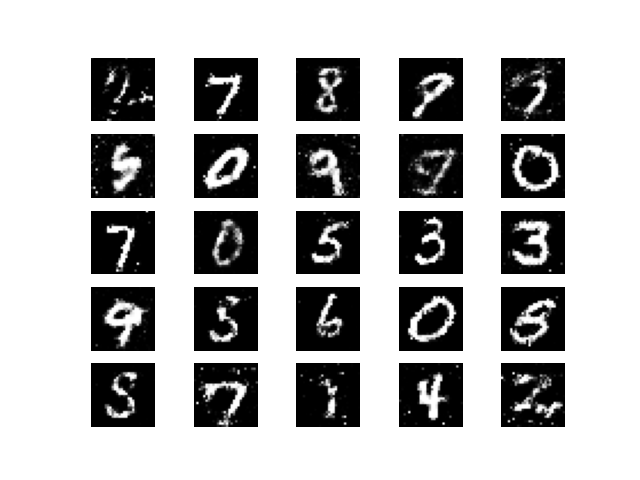

## Проверка обученного генератора

### Для одного изображения

1/1 [==============================] - 0s 25ms/step


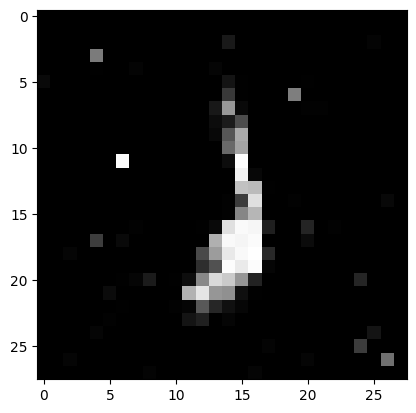

In [ ]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn

# model = load_model('generator_model_final.h5')
model = generator

# Чтобы создать одинаковое изображение, каждый раз подавайте один и тот же вектор.

#Для создания случайных изображений каждый раз...
vector = randn(100) #Вектор случайных чисел (создает столбец, необходимо изменить форму)
vector = vector.reshape(1, 100)

# сгенеруем изображение
X = model.predict(vector)

# Выведем результат
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()


### Для нескольких изображений

In [ ]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt

Генерируем начальные векторы случайного шума для каждого изображения:

In [ ]:
def generate_latent_points(latent_dim, n_samples):
  # генерируем случайные вектора по количеству n_samples
	x_input = randn(latent_dim * n_samples)
	# переформировать в пакет входных данных для сети
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

Сохраняем сгенерированные изображения (в палитре инверсии градация серого)

In [ ]:
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

1/1 [==============================] - 0s 22ms/step


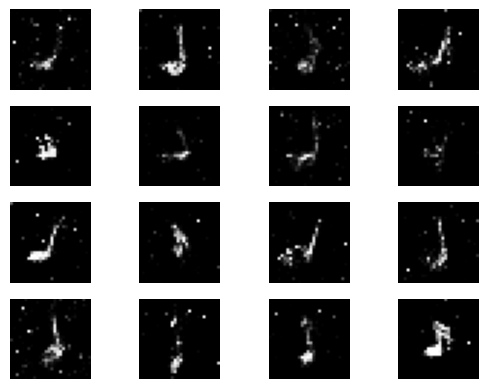

In [ ]:
# model = load_model('generator_model_final.h5')
model = generator


# Сгенерируем 16 векторов случайного шума
latent_points = generate_latent_points(100, 16)

# Генерируем изображения га основе сгенерированных векторов
X = model.predict(latent_points)

# Выводим результаты
save_plot(X, 4)  # Таблица 4x4 (Можно изменить на 5 для генерации и вывода 25 изображений)

# **Задание №2.** Обучите генератор воспризводить сложные изображения. Датасет выберите по желанию.

In [6]:
from tensorflow.keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU, ELU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
from imutils import paths
import cv2
import os

In [7]:
img_rows = 32
img_cols = 32
channels = 3
img_shape = (img_rows, img_cols, channels)

In [8]:
def build_generator():
    # Вектор случайного шума, используемый в качестве входного слоя для Генератора:
    noise_shape = (100,) # 1D массив размером 100 (латентный вектор / шум)

    model = Sequential()

    #Alpha - α - это гиперпараметр, который управляет базовым значением, на который функция
    # функция домножает отрицательные входы сети.
    #Momentum - «задержка» в обучении среднего значения и дисперсии, поэтому шум из-за мини-пакета можно игнорировать
    # Ссылка: https://medium.com/@ilango100/batchnorm-fine-tune-your-booster-bef9f9493e22

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))#model.add(ELU(alpha=0.2))#
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    # Генерация изображения

    return Model(noise, img)

In [9]:
def build_discriminator():
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)  # предположение дискриминатора о том, является ли входное изображение реальным или нет.

    return Model(img, validity)

In [ ]:
from tensorflow.keras.models import load_model, save_model

def save(gan, generator, discriminator):
    root_path = ''
    discriminator.trainable = False
    save_model(gan, root_path+'gan')
    discriminator.trainable = True
    save_model(generator, root_path + 'generator')
    save_model(discriminator, root_path + 'discriminator')

def load():
    root_path = ''
    discriminator = load_model(root_path + 'discriminator')
    generator = load_model(root_path + 'generator')
    gan = load_model(root_path + 'gan')
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

def train(epochs, batch_size=128, save_interval=50):
    #compression_size = 28
    # Загружаем набор данных
    (X_train, _), (_, _) = cifar10.load_data()
    # Преобразование в тип float и нормализация от -1 до 1 (можно также от 0 до 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    #Добавляем размерность каналов. В качестве входных данных для наших gen и discr. имеет форму 28x28x1.
    #X_train = np.expand_dims(X_train, axis=3)
    half_batch = int(batch_size / 2)


    #Обучаем Дискриминатор,
    # выбираем случайную партию изображений из нашего истинного набора данных,
    # генерируем набор изображений с помощью Генератора, затем подаём оба набора изображений в наш Дискриминатор,
    # и, наконец, вычисляем параметры функции потерь для реальных и сгенерированных
    #  (поддельных) изображений, а также комбинированные потери.

    for epoch in range(epochs):

        # ---------------------
        #  Обучение Дискриминатора
        # ---------------------

        # Выберите случайную половину партии реальных изображений
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]


        noise = np.random.normal(0, 1, (half_batch, 100))

        # Сгенерируем половину партии поддельных изображений
        gen_imgs = generator.predict(noise)

        # Обучение дискриминатора на реальных и поддельных изображениях отдельно.
        # Исследования показали, что раздельное обучение более эффективно.
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

        # Процесс обучения происходит с помощью метода train_on_batch()
        # Ссылка:https://keras.io/api/models/model_training_apis/

        # Вычисление средней потери от реальных и поддельных изображений.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #И в том же цикле мы обучаем наш Генератор, задавая входной шум
        # и в конечном итоге обучая Генератор тому, чтобы Дискриминатор
        # помечал его образцы как достоверные задавая градиентные потери.

        # ---------------------
        #  Обучение Генератора
        # ---------------------

        #Создаём векторы случайного шума в качестве входных данных для генератора.
        # На каждую партию необходимо создать свой вектор.
        # Шум основано на нормальном распределении (от 0 до 1).
        # Выходные данные будут иметь размер (размер партии, 100)

        noise = np.random.normal(0, 1, (batch_size, 100))

        # Генератору необходимо добиться того, чтобы дискриминатор пометил сгенерированные образцы
        # как истинные (1)
        # Здесь генератор пытается "обмануть" дискриминатор, чтобы тот "поверил", в то
        # что сгенерированный образ является истинным (отсюда значение 1 для y)
        valid_y = np.array([1] * batch_size) #Создает массив всех единиц размера size=batch size

        # Генератор является частью комбинированной системы, где он напрямую связан с дискриминатором.
        # Обучим генератор, используя шум в качестве x и 1 в качестве y.
        # Опять же, 1 в качестве выхода, так как он состязательный,
        # и если генератор отлично справился со своей р работой по следованию дискриминатору, то на выходе будет 1 (истина).

        g_loss = combined.train_on_batch(noise, valid_y)


#Дополнительно, чтобы мы могли отслеживать процесс обучения, мы выводим на печать
# прогресс и сохраняем вывод образцов изображений в зависимости от заданного интервала эпох,
# а также по желанию, можем сохранять модель.

        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)
            if epoch % 1000 == 0:
                # save(combined, generator, discriminator)
                save(combined, generator, discriminator)

def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("mnist_%d.png" % epoch)
    plt.close()

optimizer = tf.keras.optimizers.legacy.Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False

valid = discriminator(img)  #Проверка достоверности сгенерированного изображения

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

train(epochs=25000, batch_size=32, save_interval=2000)
generator.save('generator_model_final.h5')

Выходные данные были обрезаны до нескольких последних строк (5000).
933 [D loss: 0.625594, acc.: 59.38%] [G loss: 1.268673]
1/1 [==============================] - 0s 25ms/step
934 [D loss: 0.753051, acc.: 62.50%] [G loss: 1.171318]
1/1 [==============================] - 0s 25ms/step
935 [D loss: 0.659558, acc.: 53.12%] [G loss: 1.235111]
1/1 [==============================] - 0s 26ms/step
936 [D loss: 0.717086, acc.: 56.25%] [G loss: 1.136983]
1/1 [==============================] - 0s 26ms/step
937 [D loss: 0.753569, acc.: 43.75%] [G loss: 1.064327]
1/1 [==============================] - 0s 26ms/step
938 [D loss: 0.697597, acc.: 53.12%] [G loss: 1.163983]
1/1 [==============================] - 0s 25ms/step
939 [D loss: 0.687094, acc.: 62.50%] [G loss: 1.207256]
1/1 [==============================] - 0s 26ms/step
940 [D loss: 0.683979, acc.: 59.38%] [G loss: 1.246775]
1/1 [==============================] - 0s 25ms/step
941 [D loss: 0.650440, acc.: 68.75%] [G loss: 1.106679]
1/1 [=======